In [144]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import plotnine as p9
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap

import pickle

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# 0. load raw data after PD processing
rawdata = pd.read_csv("../data/0.rawdata/wosp22003/2-Input/protein_matrix.csv", header=0)
rawinfo = pd.read_excel("../data/0.rawdata/wosp22003/2-Input/样本实验信息登记表.xlsx", header=0, dtype=str, index_col=0).iloc[:15, :]

# 1. preprocessing rawdata

In [3]:
expr = np.log2(rawdata.iloc[:, 2:])
expr = expr - expr.median(axis=0)
rawinfo['sample_id'] = rawinfo.iloc[:, 2] +"-"+ rawinfo.iloc[:, 0]
expr.columns =  rawinfo.loc[expr.columns, 'sample_id']
expr.index = rawdata['prot'] +"|"+ rawdata["gene"]  #若某个元素为NaN值，则连接后也为NaN值。
expr = expr.loc[~expr.index.isna(), :]              #去除基因名为空的行
expr.to_csv("../data/2.prodata/protomics_expr_processed.tsv", sep="\t")

# 2. data vistualization
* violin plot
* vistualization by dimensionality reduction
    * PCA, tSNE, UMAP

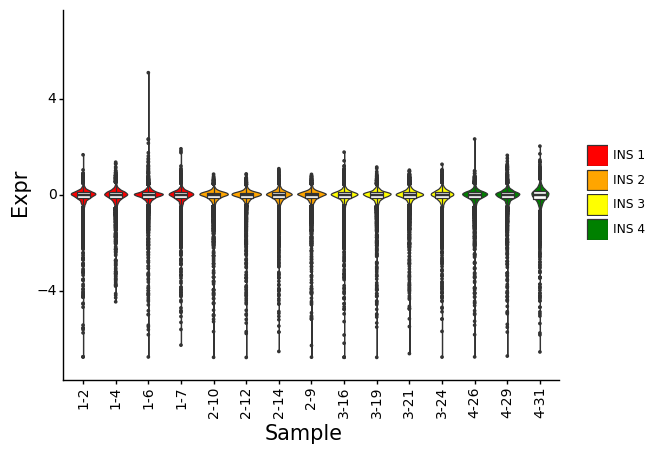

<ggplot: (8792086936074)>

In [79]:
## 2.1 violin plot
violin_dat = expr.melt(var_name="Sample", value_name="Expr")
violin_dat['Group'] = "INS " + violin_dat['Sample'].str.split("-", expand=True)[0]
violin_plot = ( p9.ggplot(p9.aes(x="Sample", y="Expr"), data=violin_dat)
                + p9.geom_violin(p9.aes(fill="Group"))
                + p9.geom_boxplot(width=0.4, outlier_size=0.5)
                + p9.scale_fill_manual(values=["red", "orange", "yellow", "green"])
                + p9.ylim([-7, 7])
                + p9.theme_classic()
                + p9.theme(axis_title=p9.element_text(color="black", size=15),
                        axis_text=p9.element_text(color="black", size=10),
                        axis_text_x=p9.element_text(angle=90),
                        legend_title=p9.element_blank())
)
p9.ggsave(violin_plot, "../res/violin_expr.pdf", units="in", width=6, height=4, verbose=False)
violin_plot

In [81]:
## 2.2 PCA
expr_scale = preprocessing.scale(expr.T, axis=0)
pca_obj = PCA(n_components=15, svd_solver="full")
pca_obj.fit(expr_scale)
components = pca_obj.transform(expr_scale)

In [82]:
pca_dat = pd.DataFrame(components[:, :2], columns=['PC1', 'PC2'])
pca_dat["Sample"] = expr.columns
pca_dat["Group"] = "INS " + pca_dat['Sample'].str.split("-", expand=True)[0]

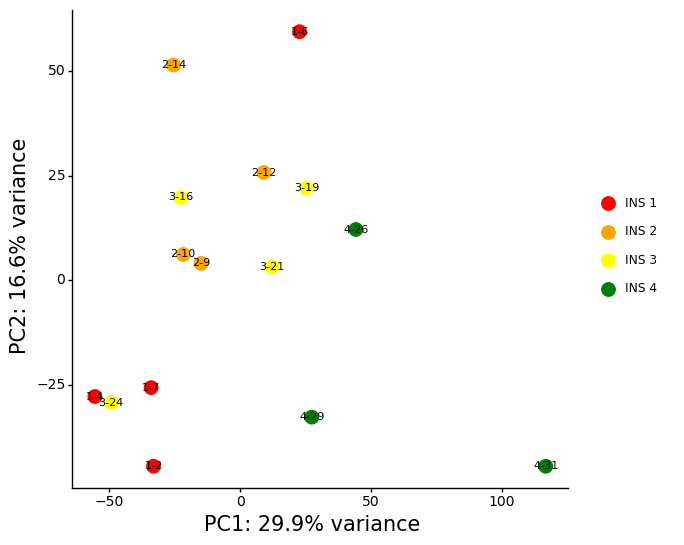

<ggplot: (8792109567097)>

In [84]:
pca_plot = ( p9.ggplot(p9.aes(x="PC1", y="PC2", color="Group"), data=pca_dat)
             + p9.geom_point(size=5)
             + p9.geom_text(p9.aes(x="PC1", y="PC2", label="Sample"), color="black", size=8)
             + p9.xlab(f"PC1: {pca_obj.explained_variance_ratio_[0]:.1%} variance")
             + p9.ylab(f"PC2: {pca_obj.explained_variance_ratio_[1]:.1%} variance")
             + p9.coord_fixed(ratio=1.6)
             + p9.scale_color_manual(values=["red", "orange", "yellow", "green"])
             + p9.theme_classic()
             + p9.theme(axis_title=p9.element_text(color="black", size=15),
                        axis_text=p9.element_text(color="black", size=10),
                        legend_title=p9.element_blank())
)
p9.ggsave(pca_plot, "../res/pca_expr.pdf", units="in", width=5, height=4, verbose=False)
pca_plot

In [99]:
## 2.3 tSNE
tsne_obj = TSNE(n_components=2, perplexity=4, init="pca", learning_rate="auto", method='exact')
tsne_obj.fit(expr_scale)

tsne_dat = pd.DataFrame(tsne_obj.embedding_, columns=['tSNE1', 'tSNE2'])
tsne_dat["Sample"] = expr.columns
tsne_dat["Group"] = "INS " + tsne_dat['Sample'].str.split("-", expand=True)[0]

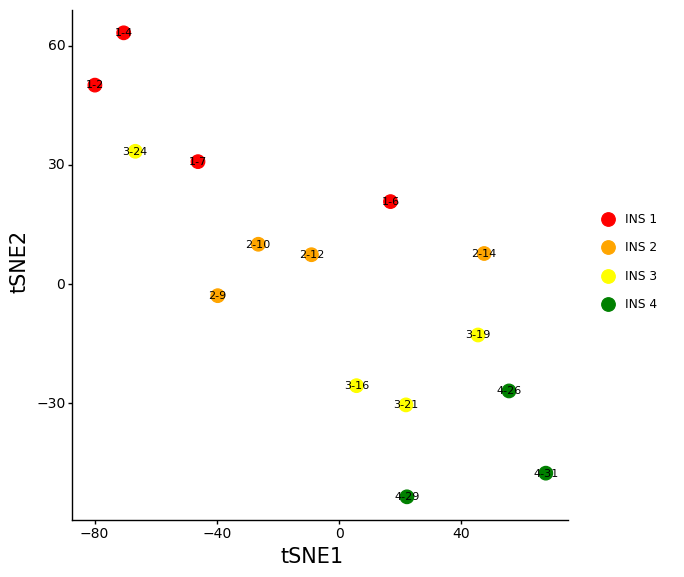

<ggplot: (8792087044467)>

In [107]:
tsne_plot = ( p9.ggplot(p9.aes(x="tSNE1", y="tSNE2", color="Group"), data=tsne_dat)
             + p9.geom_point(size=5)
             + p9.geom_text(p9.aes(x="tSNE1", y="tSNE2", label="Sample"), color="black", size=8)
             + p9.coord_equal(ratio=1.3)
             + p9.scale_color_manual(values=["red", "orange", "yellow", "green"])
             + p9.theme_classic()
             + p9.theme(axis_title=p9.element_text(color="black", size=15),
                        axis_text=p9.element_text(color="black", size=10),
                        legend_title=p9.element_blank())
)
p9.ggsave(tsne_plot, "../res/tsne_expr.pdf", units="in", width=5, height=4, verbose=False)
tsne_plot

In [127]:
## 2.4 UMAP
umap_obj = umap.UMAP(n_neighbors=4, n_jobs=4)
umap_obj.fit(expr_scale)

umap_dat = pd.DataFrame(umap_obj.embedding_, columns=['UMAP1', 'UMAP2'])
umap_dat["Sample"] = expr.columns
umap_dat["Group"] = "INS " + umap_dat['Sample'].str.split("-", expand=True)[0]

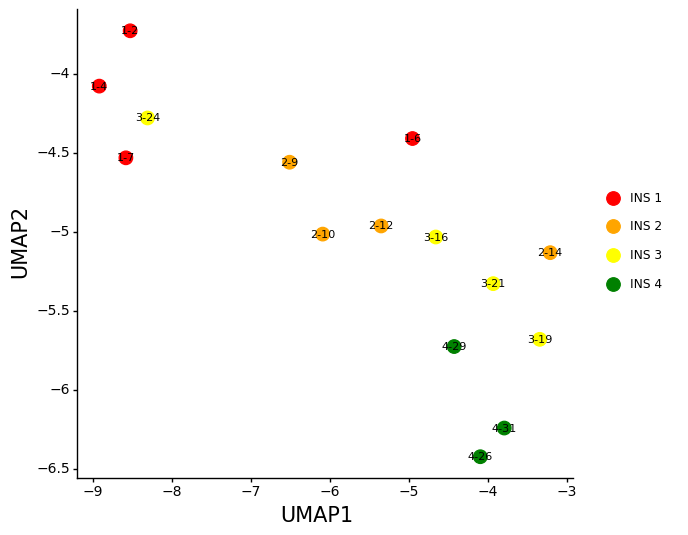

<ggplot: (8792087191287)>

In [140]:
umap_plot = ( p9.ggplot(p9.aes(x="-UMAP1", y="-UMAP2", color="Group"), data=umap_dat)
             + p9.geom_point(size=5)
             + p9.geom_text(p9.aes(x="-UMAP1", y="-UMAP2", label="Sample"), color="black", size=8)
             + p9.coord_equal(ratio=2)
             + p9.scale_color_manual(values=["red", "orange", "yellow", "green"])
             + p9.xlab("UMAP1") + p9.ylab("UMAP2")
             + p9.theme_classic()
             + p9.theme(axis_title=p9.element_text(color="black", size=15),
                        axis_text=p9.element_text(color="black", size=10),
                        legend_title=p9.element_blank())
)
p9.ggsave(umap_plot, "../res/umap_expr.pdf", units="in", width=5, height=4, verbose=False)
umap_plot

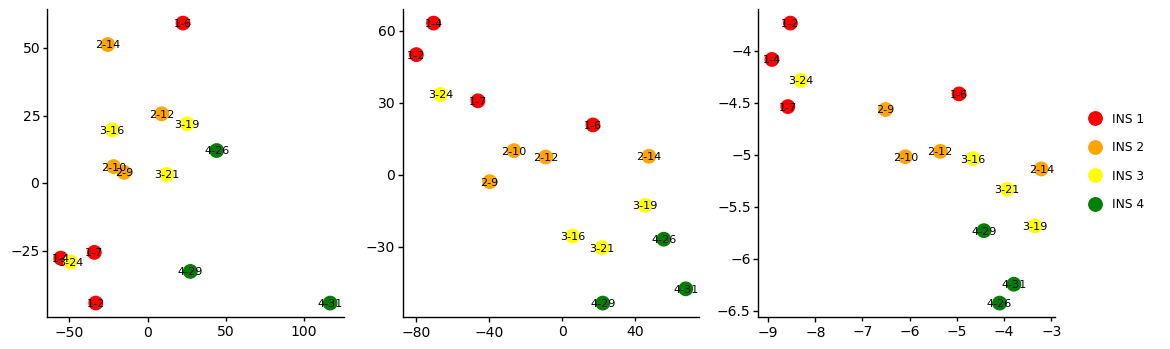

In [171]:
fig = (p9.ggplot()+p9.geom_blank()+p9.theme_void()).draw()
fig.set_size_inches(13, 4)

gs = mpl.gridspec.GridSpec(1,3)  ## 初始化多个窗口
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[0,2])
## 为多个窗口绘图
_ = pca_plot._draw_using_figure(fig,[ax1])
_ = tsne_plot._draw_using_figure(fig,[ax2])
_ = umap_plot._draw_using_figure(fig,[ax3])

plt.savefig("../res/DR_merge.pdf")
plt.show()

In [143]:
# save
pickle.dump([expr_scale, pca_obj, tsne_obj, umap_obj], open('../res/0.preprocessing_DR.pkl', 'wb'))

In [ ]:
expr_scale, pca_obj, tsne_obj, umap_obj = 